## Visual Tales: Image Caption Generator

#### Step 1: Import the required libraries

In [1]:
# linear algebra 
import numpy as np   
# data processing, CSV file I / O (e.g. pd.read_csv) 
import pandas as pd   
import os 
import tensorflow as tf 
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.models import Model 
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation 
from keras.layers import concatenate, BatchNormalization, Input
from tensorflow.keras.layers import add 
from keras.utils import to_categorical, plot_model 
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
import matplotlib.pyplot as plt  # for plotting data 
import cv2 

#### Step 2: Load the descriptions

In [2]:
def load_description(text): 
    mapping = dict() 
    for line in text.split("\n"): 
        token = line.split("\t") 
        if len(line) < 2:   # remove short descriptions 
            continue
        img_id = token[0].split('.')[0] # name of the image 
        img_des = token[1]              # description of the image 
        if img_id not in mapping: 
            mapping[img_id] = list() 
        mapping[img_id].append(img_des) 
    return mapping 
  
token_path = 'Flickr8k_text/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read() 
descriptions = load_description(text) 
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [3]:
import string
def clean_description(desc): 
    for key, des_list in desc.items(): 
        for i in range(len(des_list)): 
            caption = des_list[i] 
            caption = [ch for ch in caption if ch not in string.punctuation] 
            caption = ''.join(caption) 
            caption = caption.split(' ') 
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()] 
            caption = ' '.join(caption) 
            des_list[i] = caption 
  
clean_description(descriptions) 
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

#### Step 4: Generate the Vocabulary

In [4]:
def to_vocab(desc): 
    words = set() 
    for key in desc.keys(): 
        for line in desc[key]: 
            words.update(line.split()) 
    return words 
vocab = to_vocab(descriptions)

#### Step 5: Load the images

In [5]:
import glob 
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg') 
  
train_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n") 
train_img = []  # list of all images in training set 
for im in img: 
    if(im[len(images):] in train_images): 
        train_img.append(im) 
          
# load descriptions of training set in a dictionary. Name of the image will act as ey 
def load_clean_descriptions(des, dataset): 
    dataset_des = dict() 
    for key, des_list in des.items(): 
        if key+'.jpg' in dataset: 
            if key not in dataset_des: 
                dataset_des[key] = list() 
            for line in des_list: 
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc) 
    return dataset_des 

train_descriptions = load_clean_descriptions(descriptions, train_images) 
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


#### Step 6: Extract the feature vector from all images

In [6]:
from keras.preprocessing.image import load_img, img_to_array 
def preprocess_img(img_path): 
    # inception v3 excepts img in 299 * 299 * 3 
    img = load_img(img_path, target_size = (299, 299)) 
    x = img_to_array(img) 
    # Add one more dimension 
    x = np.expand_dims(x, axis = 0) 
    x = preprocess_input(x) 
    return x 
  
def encode(image): 
    image = preprocess_img(image) 
    vec = model.predict(image) 
    vec = np.reshape(vec, (vec.shape[1])) 
    return vec 
  
base_model = InceptionV3(weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5') 
model = Model(base_model.input, base_model.layers[-2].output) 
# run the encode function on all train images and store the feature vectors in a list 
encoding_train = {} 
for img in train_img: 
    encoding_train[img[len(images):]] = encode(img) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

#### Step 7: Tokenizing the vocabulary

In [7]:
# list of all training captions 
all_train_captions = [] 
for key, val in train_descriptions.items(): 
    for caption in val: 
        all_train_captions.append(caption) 
  
# consider only words which occur atleast 10 times 
vocabulary = vocab 
threshold = 10 # you can change this value according to your need 
word_counts = {} 
for cap in all_train_captions: 
    for word in cap.split(' '): 
        word_counts[word] = word_counts.get(word, 0) + 1
  
vocab = [word for word in word_counts if word_counts[word] >= threshold] 
  
# word mapping to integers 
ixtoword = {} 
wordtoix = {} 
  
ix = 1
for word in vocab: 
    wordtoix[word] = ix 
    ixtoword[ix] = word 
    ix += 1

vocab_size = len(ixtoword) + 1

# find the maximum length of a description in a dataset 
max_length = max(len(des.split()) for des in all_train_captions) 
max_length

34

#### Step 8: Glove vector embeddings

In [8]:
# train_features = {}

# # Load and encode each image in the training set
# for img in train_img:
#     img_id = img.split('/')[-1]  # Get the image file name
#     train_features[img_id] = encode(img)

X1, X2, y = list(), list(), list() 
for key, des_list in train_descriptions.items(): 
    pic = encoding_train[key + '.jpg'] 
    for cap in des_list: 
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix] 
        for i in range(1, len(seq)): 
            in_seq, out_seq = seq[:i], seq[i] 
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0] 
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0] 
            # store 
            X1.append(pic) 
            X2.append(in_seq) 
            y.append(out_seq) 
  
X2 = np.array(X2) 
X1 = np.array(X1) 
y = np.array(y) 
  
# load glove vectors for embedding layer 
embeddings_index = {} 
golve_path ='glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read() 
for line in glove.split("\n"): 
    values = line.split(" ") 
    word = values[0] 
    indices = np.asarray(values[1: ], dtype = 'float32') 
    embeddings_index[word] = indices 
  
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim)) 
for word, i in wordtoix.items(): 
    emb_vec = embeddings_index.get(word) 
    if emb_vec is not None: 
        emb_matrix[i] = emb_vec 
emb_matrix.shape

(1652, 200)

#### Step 9: Define the model

In [9]:
# define the model 
ip1 = Input(shape = (2048, )) 
fe1 = Dropout(0.2)(ip1) 
fe2 = Dense(256, activation = 'relu')(fe1) 
ip2 = Input(shape = (max_length, )) 
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2) 
se2 = Dropout(0.2)(se1) 
se3 = LSTM(256)(se2) 
decoder1 = add([fe2, se3]) 
decoder2 = Dense(256, activation = 'relu')(decoder1) 
outputs = Dense(vocab_size, activation = 'softmax')(decoder2) 
model = Model(inputs = [ip1, ip2], outputs = outputs)

#### Step 10: Training the model



In [10]:
model.layers[2].set_weights([emb_matrix]) 
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam') 
model.fit([X1, X2], y, epochs = 50, batch_size = 256) 
# you can increase the number of epochs for better results

Epoch 1/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 191s 165ms/step - loss: 4.4613
Epoch 2/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 191s 167ms/step - loss: 3.2003
Epoch 3/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 190s 167ms/step - loss: 2.9197
Epoch 4/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 216s 189ms/step - loss: 2.7519
Epoch 5/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 231s 202ms/step - loss: 2.6218
Epoch 6/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 232s 203ms/step - loss: 2.5274
Epoch 7/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 227s 198ms/step - loss: 2.4356
Epoch 8/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 214s 188ms/step - loss: 2.3664
Epoch 9/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 183s 160ms/step - loss: 2.2984
Epoch 10/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 186s 163ms/step - loss: 2.2510
Epoch 11/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 154s 135ms/step - loss: 2.1999
Epoch 12/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 148s 130ms/step - loss: 2.1605
Epoch 13/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 150s 131ms/step - loss: 2.1165
Epoch 14/50
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 148s

In [11]:
model.save('model_weights.h5')

#### Step 11: Predicting the output

In [12]:
def greedy_search(pic): 
    start = 'startseq'
    for i in range(max_length): 
        seq = [wordtoix[word] for word in start.split() if word in wordtoix] 
        seq = pad_sequences([seq], maxlen = max_length) 
        yhat = model.predict([pic, seq]) 
        yhat = np.argmax(yhat) 
        word = ixtoword[yhat] 
        start += ' ' + word 
        if word == 'endseq': 
            break
    final = start.split() 
    final = final[1:-1] 
    final = ' '.join(final) 
    return final

In [13]:
import string
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Preprocess the image using InceptionV3
def test_preprocess_img(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

# Encode the image using the InceptionV3 model
def test_encode(image):
    image = test_preprocess_img(image)
    vec = image_model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

test_base_model = InceptionV3(weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5') 
image_model = Model(test_base_model.input, test_base_model.layers[-2].output) 
# Evaluation
test_images_path = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = open(test_images_path, 'r', encoding='utf-8').read().split("\n")
t_images = 'Flicker8k_Dataset/'
t_img = glob.glob(os.path.join(t_images, '*.jpg'))
test_img = [im for im in t_img if os.path.basename(im) in test_images]

test_descriptions = load_clean_descriptions(descriptions, test_images)

encoding_test = {}

for img in test_img:
    encoding_test[os.path.basename(img)] = test_encode(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

In [14]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 200)   │    330,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 200)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    467,968 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1652)      │    424,564 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,779,006 (18.23 MB)

 Trainable params: 1,482,868 (5.66 MB)

 Non-trainable params: 330,400 (1.26 MB)

 Optimizer params: 2,965,738 (11.31 MB)

In [15]:
def greedy_search(pic): 
    start = 'startseq'
    pic = np.expand_dims(pic, axis=0)
    
    for i in range(max_length): 
        seq = [wordtoix[word] for word in start.split() if word in wordtoix] 
        seq = pad_sequences([seq], maxlen = max_length) 
        if(pic.shape != (1, 2048) ):
            continue
        yhat = model.predict([pic, seq]) 
        yhat = np.argmax(yhat) 
        word = ixtoword[yhat] 
        start += ' ' + word 
        if word == 'endseq': 
            break
    final = start.split() 
    final = final[1:-1] 
    final = ' '.join(final) 
    return final

#### Step 12: Visualization

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Generate captions and evaluate
actual, predicted = list(), list()

images_to_show = []

for key, desc_list in test_descriptions.items():
    y_pred = greedy_search(encoding_test[key + '.jpg'])
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(y_pred.split())

    image_path = os.path.join('Flicker8k_Dataset', key + '.jpg')
    images_to_show.append((image_path, y_pred))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [22]:
print(actual[0])
print(predicted[0])

[['startseq', 'blond', 'woman', 'in', 'blue', 'shirt', 'appears', 'to', 'wait', 'for', 'ride', 'endseq'], ['startseq', 'blond', 'woman', 'is', 'on', 'the', 'street', 'hailing', 'taxi', 'endseq'], ['startseq', 'woman', 'is', 'signaling', 'is', 'to', 'traffic', 'as', 'seen', 'from', 'behind', 'endseq'], ['startseq', 'woman', 'with', 'blonde', 'hair', 'wearing', 'blue', 'tube', 'top', 'is', 'waving', 'on', 'the', 'side', 'of', 'the', 'street', 'endseq'], ['startseq', 'the', 'woman', 'in', 'the', 'blue', 'dress', 'is', 'holding', 'out', 'her', 'arm', 'at', 'oncoming', 'traffic', 'endseq']]
['young', 'boy', 'wearing', 'blue', 'shirt', 'is', 'walking', 'down', 'sidewalk']


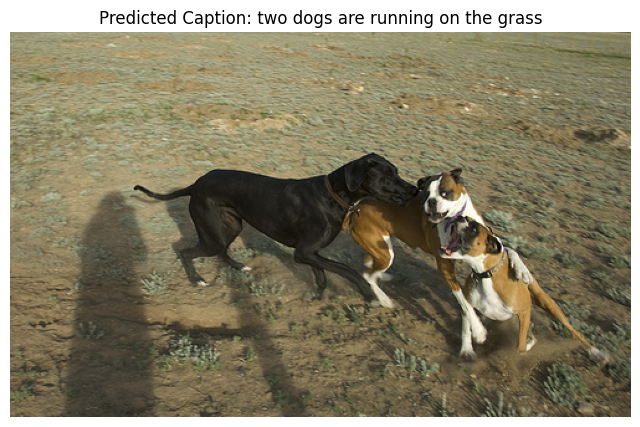

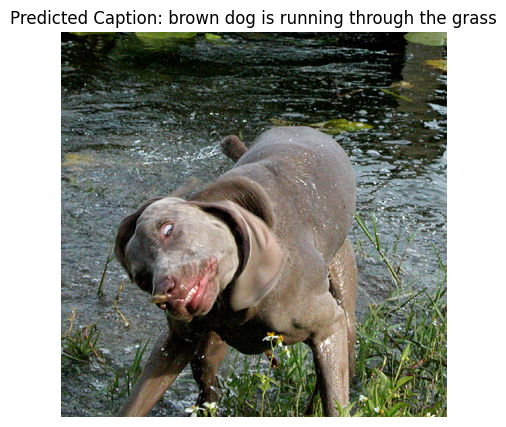

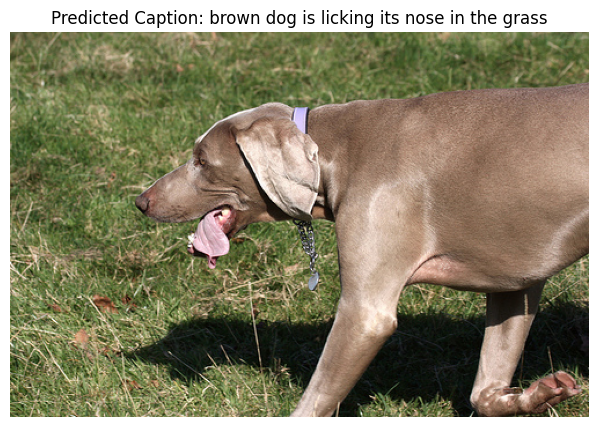

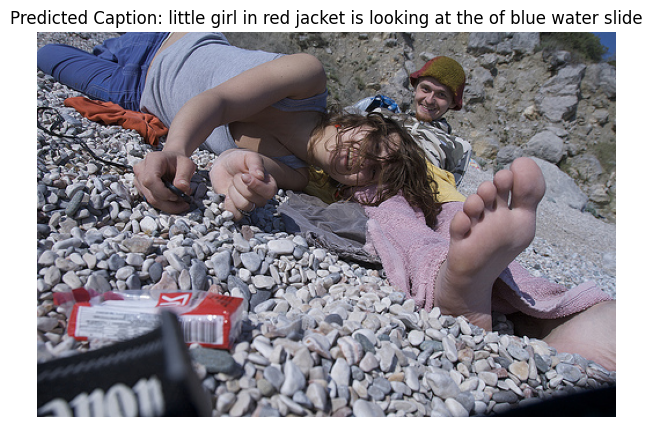

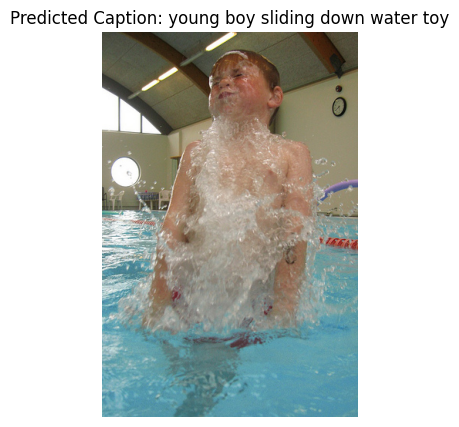

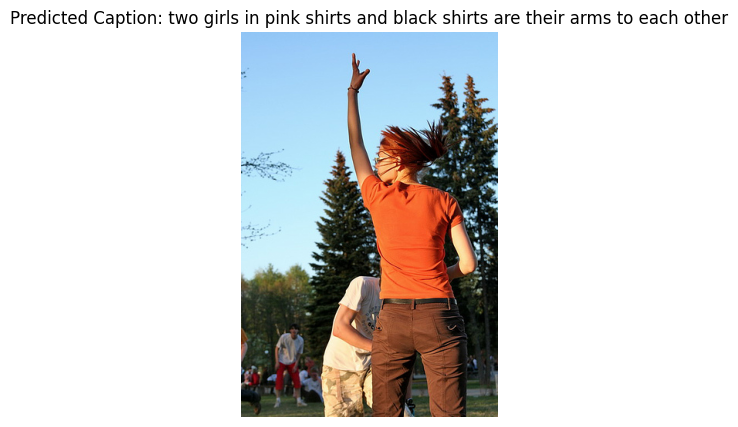

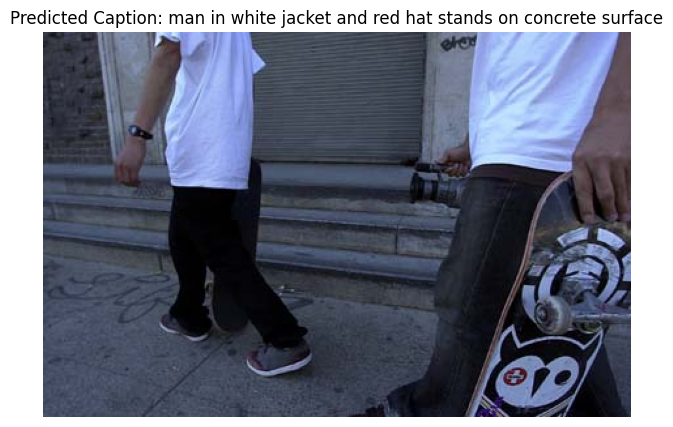

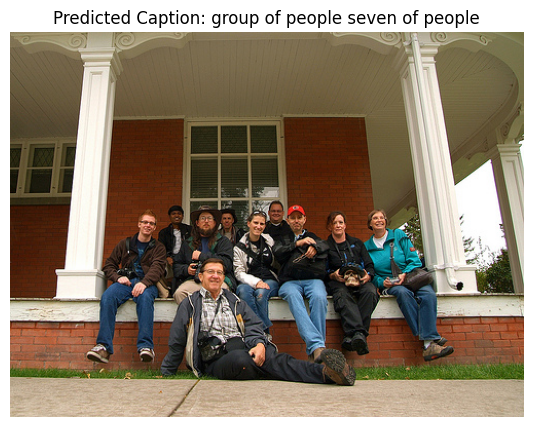

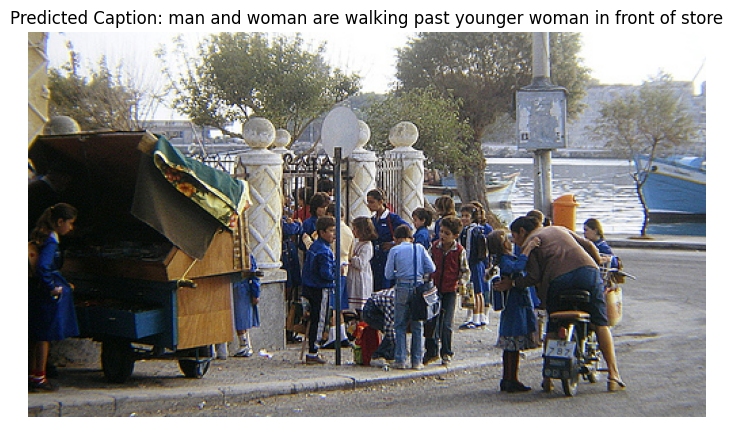

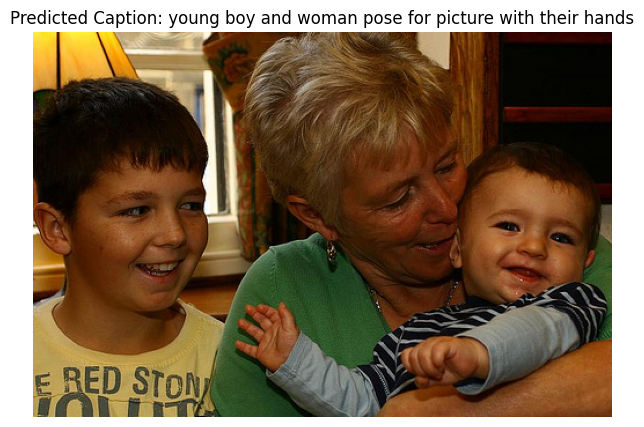

In [24]:
random_images_to_show = random.sample(images_to_show, min(len(images_to_show), 10))

# Visualization
for img_path, caption in random_images_to_show:
    # Load and display image
    img = mpimg.imread(img_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Caption: {caption}")
    plt.show()

In [ ]:
random_images_to_show = random.sample(images_to_show, min(len(images_to_show), 10))

# Visualization
for img_path, caption in random_images_to_show:
    # Load and display image
    img = mpimg.imread(img_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Caption: {caption}")
    plt.show()